# Scraping Data for Flight Price Prediction


First, we import necessary libraries required for our data


In [48]:
from bs4 import BeautifulSoup
from string import Template
from urllib.request import urlopen
import re
from urllib.request import urlopen, Request
from selenium import webdriver
from datetime import datetime, timedelta
import time
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import csv
# from ydata_profiling import ProfileReport
# from pandas_profiling import ProfileReport

The libraries we imported and their usage:
- `BeautifulSoup`: for parsing HTML and XML documents and easy extraction of data.
- `Template` (from `string`): to substitute values into strings with placeholders.
- `urlopen` (from `urllib.request`): to open URLs and retrieve their contents using HTTP.
- `re`: for regular expressions, pattern matching and string manipulation.
- `webdriver` (from `selenium`): for automated web browser interaction, used for web scraping and testing.
- `datetime` (from `datetime`): for working with dates and times in Python.
- `time`: for measuring elapsed time and handling time-sensitive operations.
- `os`: for interacting with the file system and executing system commands.

# Kayak Flight Price Data
We are using url of Kayak website to extract our data.Kayak is a popular travel search engine and fare comparator to search for flights, hotels, car rentals, and also vacation packages.The users can search  for flights based on their desired destinations, travel dates, and other preferences. Kayak aggregates flight information from various airlines and travel agencies.  The url that we will be using if Kayak flight price : https://www.ca.kayak.com/flights/KTM-BLR/2024-04-14?sort=price_a

In [5]:
# url = "https://www.ca.kayak.com/flights/KTM-BLR/2024-04-14?sort=price_a"

# Deafaults are toronto, New York and 2024-04-14
def get_url(departure="YTO", destination="NYC", date="2024-04-14"):
    return f'https://www.ca.kayak.com/flights/{departure}-{destination}/{date}?sort=price_a'
url = get_url()
print(url)
url = get_url(departure="KTM")
print(url)

https://www.ca.kayak.com/flights/YTO-NYC/2024-04-14?sort=price_a
https://www.ca.kayak.com/flights/KTM-NYC/2024-04-14?sort=price_a


Now that we have the urls, we need to figure out where our relevant information is in the webpage. For that we will use the BeautifulSoup library that we have imported already. Now, we will try to convert the webpage to bs object.

In [6]:
url = get_url()
# url = get_url(departure="KTM")
page = urlopen(url)
html = page.read().decode("utf-8")
soup = BeautifulSoup(html, "html.parser")
print(soup.get_text())




What is a bot?

Skip to main content  Sign inFlightsStaysCarsFlight+HotelAsk KAYAKBETAExploreFlight TrackerBest Time to TravelTripsKAYAK for BusinessNEWEnglishArgentinaAustraliaBelgiëFRNLBoliviaBrasilCanadaENFRChile中国ColombiaCosta RicaDanmarkDeutschlandDEENEcuadorEl SalvadorEspañaESCAFranceΕλλάδαGuatemalaHonduras香港EN繁IndiaIndonesiaIDENIrelandIsraelENHEItalia日本MalaysiaENBMMéxicoNederlandNew ZealandNicaraguaNorgePanamáParaguayPerúPhilippinesPolskaPortugalPuerto RicoRepública DominicanaRomâniaSchweizFRDESingaporeEN简South Africa대한민국SuomiSverige台灣TürkiyeUnited Arab EmiratesUnited KingdomUnited StatesENESUruguayVenezuelaViệt NamENVIÖsterreichČeská republikaУкраїнаSaudi ArabiaARENประเทศไทยTHENIf you are seeing this page, it means that KAYAK thinks you are a "bot", and the page you were trying to get to is only useful for humans.What is a bot?A bot, or robot, or crawler is software that visits web sites and collects data from them without a human present. Search engines like Google use rob

**This is the output we got from the above step:**
*" you are seeing this page, it means that KAYAK thinks you are a "bot", and the page you were trying to get to is only useful for humans.What is a bot?A bot, or robot, or crawler is software that visits web sites and collects data from them without a human present. Search engines like Google use robots to build up search results. KAYAK uses bots to search for travel deals. Bots are generally a good thing, but some web pages are for humans only. For example, we don't want bots running about trying to book airline tickets. They tend to try to cram large suitcases in the overhead bin, and they prattle on about celebrities they know while you are trying to watch the movie.But I am not a bot! I'm human!Probably something about the web browser you are using made KAYAK think you are a bot. Please send us a message and we'll try to figure out what went wrong.If you've been using KAYAK successfully up until now, try closing your browser and starting again.Learn more about bots on Wikipedia.©2024 KAYAKTop International Flight Routes.Cheap flights, h ....."*

**This means that there was a countermeasure to prevent from the bots using the site to track prices. We need to find a way around it.**

**Receiving Kayak's data without triggerring bot detection**
We used selenium webdriver to emulate human interaction with the website, allowing us to bypass the bot prevention.

In [7]:
# Initialize a headless browser
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(options=options)

url = get_url()
driver.get(url)

In [8]:
# Get the page source (HTML)
page_source = driver.page_source

soup = BeautifulSoup(page_source, "html.parser")
print(soup.get_text())









































































































        
YTO to NYC, 14/4








Skip to main content



  Sign inSign inFlightsStaysCarsFlight+HotelAsk KAYAKBETAExploreFlight TrackerBest Time to TravelTripsKAYAK for BusinessNEWEnglishArgentinaAustraliaBelgiëFRNLBoliviaBrasilCanadaENFRChile中国ColombiaCosta RicaDanmarkDeutschlandDEENEcuadorEl SalvadorEspañaESCAFranceΕλλάδαGuatemalaHonduras香港EN繁IndiaIndonesiaIDENIrelandIsraelENHEItalia日本MalaysiaENBMMéxicoNederlandNew ZealandNicaraguaNorgePanamáParaguayPerúPhilippinesPolskaPortugalPuerto RicoRepública DominicanaRomâniaSchweizFRDESingaporeEN简South Africa대한민국SuomiSverige台灣TürkiyeUnited Arab EmiratesUnited KingdomUnited StatesENESUruguayVenezuelaViệt NamENVIÖsterreichČeská republikaУкраїнаSaudi ArabiaARENประเทศไทยTHEN









Go to flights filters Edit search form Go to flights results section












Edit search form Go to flights results section










Go to flights filters E

We were able to obtain the data using the selenium webdriver, but we only get 15 records at one time. In the next steps we will extract the data and save it into a structured csv format.

## Extracting data into proper format
We have written functions to parse the Kayak search results page and extract information corresponding to the columns that we require the data in.We are using  `Beautiful soup` library to parse the data. The columns that we will have in our final csv file are:
- Departure Airport
- Arrival Airport
- Departure Time
- Arrival Time
- Flight Duration
- Number of Stops
- Prices

In [22]:
def get_formatted_airports(data):
    airport_info = (data[:3], data[3:])
    return airport_info

def get_departures_and_arrivals(soup):
    data = soup.find_all(
        "span", class_="EFvI-ap-info")
    airports = [get_formatted_airports(span.get_text()) for span in data]
    departures = airports[::2]
    arrivals = airports[1::2]
    return departures, arrivals

def get_departure_and_arrival_times(soup):
    data = soup.find_all("div", class_="vmXl vmXl-mod-variant-large")
    time_info = [div.get_text() for div in data]
    departure_times = []
    arrival_times = []
    for time_string in time_info:
        departure, arrival = time_string.split(' – ')  # split time for depature and arrival
        departure_times.append(departure)
        arrival_times.append(arrival)
    return departure_times, arrival_times

def get_flight_durations_and_stops(soup):
    data = soup.find_all("div", class_="vmXl vmXl-mod-variant-default")
    formatted_durations = []
    formatted_stops = []
    for item in data:
        content = item.text.strip()
        if re.match(r'\dh|\dm', content):     # regex for hour and minute parsing
            formatted_durations.append(convert_to_minutes((content)))
        else:
            formatted_stops.append(extract_number_of_stops(content.lower()))
    return formatted_durations, formatted_stops

def convert_to_minutes(duration):
    total_minutes = 0
    hours_match = re.search(r'(\d+)h', duration)
    if hours_match:
        total_minutes += int(hours_match.group(1)) * 60
    minutes_match = re.search(r'(\d+)m', duration)
    if minutes_match:
        total_minutes += int(minutes_match.group(1))
    return total_minutes


def extract_number_of_stops(content):
    if content == 'direct':
        return 0
    elif 'stops' in content:
        return int(content.split()[0])
    elif 'stop' in content:
        return int(content.split()[0])
    else:
        return None

def get_prices(soup):
    prices = soup.find_all("div", class_="f8F1-price-text")
    formatted_prices=[]
    for price in prices:
        formatted_prices.append(price.text.strip())
    numeric_prices = [int(''.join(filter(str.isdigit, price)))
                    for price in formatted_prices]
    return numeric_prices

# Date duration to extract data
We obtain a list of dates in between a certain time interval in order to get all the url values for those times.

In [23]:
def get_date_in_between(start_date,end_date):
    date_list = []
    date_format = "%Y-%m-%d"
    # Parse the date string to a datetime object
    start_time = datetime.strptime(start_date, date_format)
    end_time = datetime.strptime(end_date,date_format)
    while start_time!= end_time:
        start_time = start_time + timedelta(days = 1)
        date_list.append(str(start_time.date()))
    return date_list



# Function to get the data from url
This function accepts the date and scrapes the flight prices for that specific date and stores it into a csv file.

In [30]:
def get_data_from_url(date="2024-04-14",header_written = False):
    url = get_url(date=date)
    print(url)
    # Configure webdriver options and launch chrome
    options = webdriver.ChromeOptions()
    driver = webdriver.Chrome(options=options)
    driver.get(url)
    time.sleep(20)  # wait for the page to load so we get all the data
    page_source = driver.page_source    # Get the page source (HTML format)
    soup = BeautifulSoup(page_source, "html.parser")   # Parse HTML using Beautifulsoup
    driver.close()    #close the page to avoid multiple loading


    # Get all the data and parse them into proper format
    departures,arrivals = get_departures_and_arrivals(soup)
    departure_time,arrival_time = get_departure_and_arrival_times(soup)
    durations, stops = get_flight_durations_and_stops(soup)
    print(len(durations))
    prices = get_prices(soup)
    print(len(prices))

    # make proper lists to append the csv file
    flight_list =[]
    for i in range(len(durations)-1):
        flight_info ={}
        flight_info['date'] = date
        flight_info['departure_city'],flight_info['departure_airport'] = departures[i]
        flight_info['arrival_city'],flight_info['arrival_airport'] = arrivals[i]
        flight_info['flight_duration']=durations[i]
        flight_info['stops'] = stops[i]
        flight_info['prices'] = prices[i]
        flight_info['departure_time'] = departure_time[i]
        flight_info['arrival_time'] = arrival_time[i]
        flight_list.append(flight_info)

    # open csv file and append
    with open('flight_date_info.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)

        writer = csv.DictWriter(csvfile, fieldnames=['date','departure_city', 'departure_airport', 'arrival_city',
                                                    'stops', 'prices', 'flight_duration', 'arrival_airport',
                                                    'departure_time', 'arrival_time'])
        if not header_written:
            if not os.path.exists("flight_4_info.csv"):  # if the file already exists, dont write header
                writer.writeheader()
            header_written = True


        for flight in flight_list:
            writer.writerow(flight)

# Start Data Scraping and Save
We begin our entire data scraping process at this stage. The scraped data is stored in csv, so this step can be skipped in order to save time and computation complexity

In [ ]:
# Set two dates beginning and end dates
start_date = "2024-3-16"
end_date = "2025-4-28"
# get dates in between
dates = get_date_in_between(start_date,end_date)
for date in dates:
    time.sleep(5)    # putting a 5 second delay
    get_data_from_url(date = date,header_written = False)


## Step 2 Data Wrangling

Data wrangling refe­rs to the process of cleaning and organizing raw data. It involves rearranging data, fixing errors and adding useful information to help in making decisions.

### 2.1 Data Exploration

In [49]:
df_flight=pd.read_csv('flight_date_info.csv')

In [50]:
df_flight

,date,departure_city,departure_airport,arrival_city,stops,prices,flight_duration,arrival_airport,departure_time,arrival_time
0,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,12:00 PM,1:30 PM
1,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,3:00 PM,4:30 PM
2,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,2:00 PM,3:30 PM
3,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,5:10 PM,6:40 PM
4,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,7:25 PM,8:55 PM
...,...,...,...,...,...,...,...,...,...,...
1478,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,90,Newark,8:40 PM,10:10 PM
1479,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,90,Newark,3:00 PM,4:30 PM
1480,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,90,Newark,7:25 PM,8:55 PM
1481,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,240,Newark,7:55 AM,9:25 AM


#### Dataset Description


The dataset provides details on flights, covering departure and arrival cities and airports, stop count, price (in an unspecified currency), flight duration, and departure and arrival times, like non-stop flights from Toronto Island (YTZ) to Newark (EWR) lasting 90 minutes at different times.

Columns  
  
•	departure_city: The city from where the flight departs.  
•	departure_airport: The  airport in the departure city from where the flight takes off.  
•	arrival_city: The city where the flight lands.  
•	stops: The number of stops the flight makes before reaching the final destination.  
•	prices: The cost of the flight.    
•	flight_duration: The total duration of the flight in minutes.  
•	arrival_airport: The airport in the arrival city where the flight lands.  
•	departure_time: The scheduled departure time of the flight.  
•	arrival_time: The scheduled arrival time of the flight.  


In [51]:
df_flight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1483 non-null   object 
 1   departure_city     1483 non-null   object 
 2   departure_airport  1483 non-null   object 
 3   arrival_city       1483 non-null   object 
 4   stops              1441 non-null   float64
 5   prices             1483 non-null   int64  
 6   flight_duration    1483 non-null   int64  
 7   arrival_airport    1483 non-null   object 
 8   departure_time     1483 non-null   object 
 9   arrival_time       1483 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 116.0+ KB


### 2.2 Formatting

'departure_time' and 'arrival_time' are converted to datetime objects using pandas to_datetime function. We are using .apply() function of pandas dataframe to do this.

In [52]:
def convert_to_time(x):
    try:
        return pd.to_datetime(x).time() # extract only time data
    except ValueError:
        return None  

In [53]:
df_flight['departure_time'] = df_flight['departure_time'].apply(convert_to_time)
df_flight['arrival_time'] = df_flight['arrival_time'].apply(convert_to_time)


In [54]:
df_flight.dtypes

date                  object
departure_city        object
departure_airport     object
arrival_city          object
stops                float64
prices                 int64
flight_duration        int64
arrival_airport       object
departure_time        object
arrival_time          object
dtype: object

### 2.3 Data Cleaning

In this process in we removed duplicated values, inaccuracies and irrelevant information to enhance the reliability and quality of the data. Here, in the beginning, we scraped the data without any date field in the file. Doing that led us to have a large number of duplicate values, as there is a high possibility that flight information might stay consistent throughout the days. Due to this, we added the date column to the dataset, making records unique by the date.

In [55]:
#Checking the duplicated values
print (df_flight.duplicated().sum())

44


In [56]:
#duplicated values are dropped from the dataframe
df_flight.drop_duplicates(keep='first', inplace=True)

In [57]:
df_flight.shape

(1439, 10)

### 2.4 Missing Values


In [58]:
#displaying number of missing values from each column
missing_values = df_flight.isnull().sum()
print(missing_values)

date                  0
departure_city        0
departure_airport     0
arrival_city          0
stops                42
prices                0
flight_duration       0
arrival_airport       0
departure_time        0
arrival_time          0
dtype: int64


In [59]:
df_flight.shape

(1439, 10)

We deal with missing values in two major ways. The ratio of missing values to the dataset is the determinant of the method we use to deal with them. If the ratio of missing values is less than 20% of the final data, we drop the entire records containing the missing items. This is done because dropping the values will have minimal impact on the whole dataset. 

In [60]:
def missing_values(df: pd.DataFrame, remove_column_ratio=0.2, impute_column_ratio=0.02):


  original_shape = df.shape

  # Get the total of missing values
  missing_values = df.isna().sum()
  overall_missing_records = missing_values.sum()

  if overall_missing_records > 0:


    # Calculate the ratio of missing records
    for columnname, value in missing_values.items():
      if value > 0:
        ratio = value / df.shape[0]
        print(f"{columnname}\n\tMissing values: {value}\n\tRatio: {ratio}")

        # Ratio greater than 20% drop the column because it is not useful
        if ratio > remove_column_ratio:
          df.drop(columns=[columnname], inplace=True)
          print(f"\t✅ Drop column {columnname}")

        # ratio too small,  replace the missing values by the mode
        elif ratio < impute_column_ratio:
          valuemode = df[columnname].mode()[0]
          df[columnname].fillna(valuemode, inplace=True)
          print(f"\t✅ Missing values are replaced by the most frequent value '{mode_value}'")

          # drop the rows that has missing values ,if the ratio is less than 20%
        else:
          df.dropna(inplace=True)
          print(f"\t✅ Remove rows with missing data")

        print("--------------------")

    print("Original shape: ", original_shape)
    print("New shape: ", df.shape)


  else:
    print("✅ No missing values")
    print("Shape: ", original_shape)
  return df

# Clean the data
df_flight = missing_values(df_flight)

stops
	Missing values: 42
	Ratio: 0.029186935371785964
	✅ Remove rows with missing data
--------------------
Original shape:  (1439, 10)
New shape:  (1397, 10)


Since we have less than 20% of missing values, we drop them

In [61]:
df_flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397 entries, 0 to 1482
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               1397 non-null   object 
 1   departure_city     1397 non-null   object 
 2   departure_airport  1397 non-null   object 
 3   arrival_city       1397 non-null   object 
 4   stops              1397 non-null   float64
 5   prices             1397 non-null   int64  
 6   flight_duration    1397 non-null   int64  
 7   arrival_airport    1397 non-null   object 
 8   departure_time     1397 non-null   object 
 9   arrival_time       1397 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 120.1+ KB


## Step 3 Data Distribution

### By Prices

We analyse the distribution of prices of the flights in our data. As the data we have extracted was sorted by prices, we have an assumption that the data distribution will be right skewed, meaning most of the values will lie on the lower side.


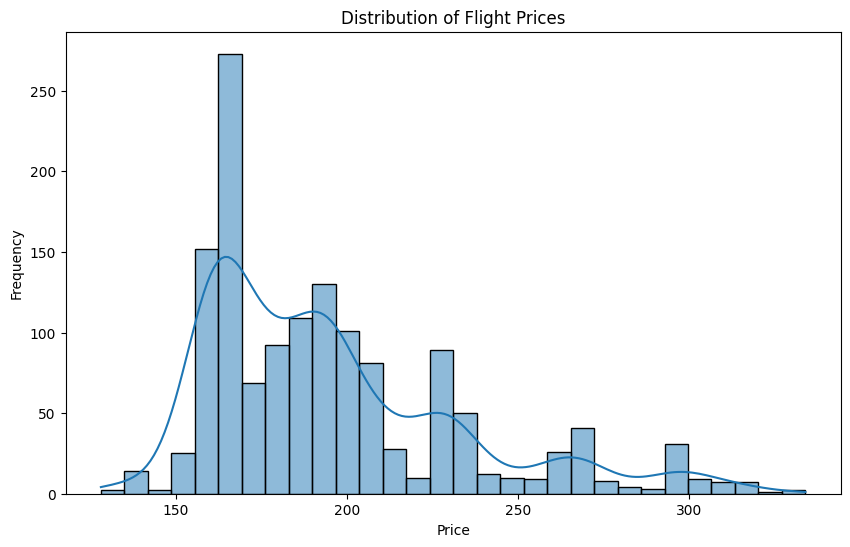

In [62]:
#Displaying the distribution of prices
plt.figure(figsize=(10, 6))
sns.histplot(df_flight['prices'], bins=30, kde=True)
plt.title('Distribution of Flight Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### By Departure Times and Arrival Times
The histogram of departure_time depicts most flights take off during the morning and fewer as the day progresses. The histogram of the arrival_time displaying a more even distribution of arrival times with noticeable increases in the early and late hours of the day. We also have a hypothesis that the cheapest flights are morning flights.

To have a proper understanding of the times and flights, we only extract the hour component of the times.

In [63]:
departure_hours = [time_data.hour for time_data in df_flight['departure_time']]
arrival_hours = [time_data.hour for time_data in df_flight['arrival_time']]

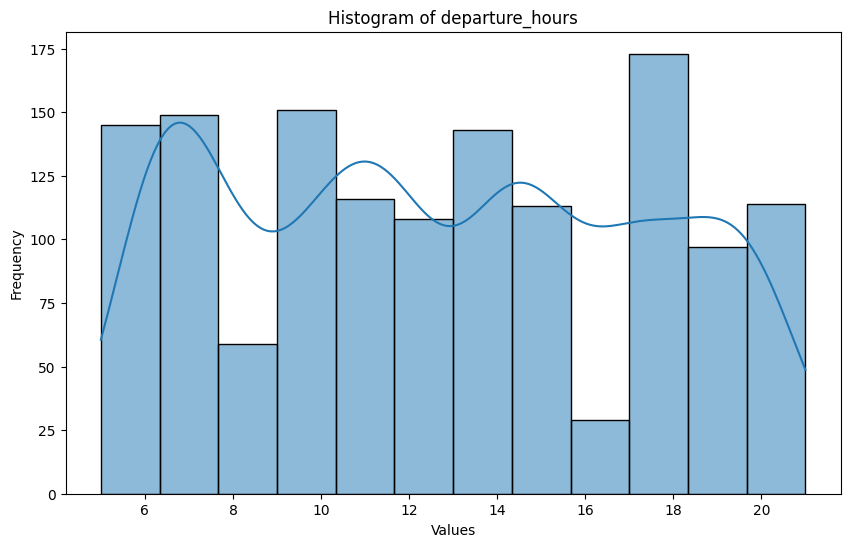

In [64]:

plt.figure(figsize=(10, 6))

# Create histograms for departure_time and arrival_time

sns.histplot(data=departure_hours, kde=True)
plt.title(f'Histogram of departure_hours')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

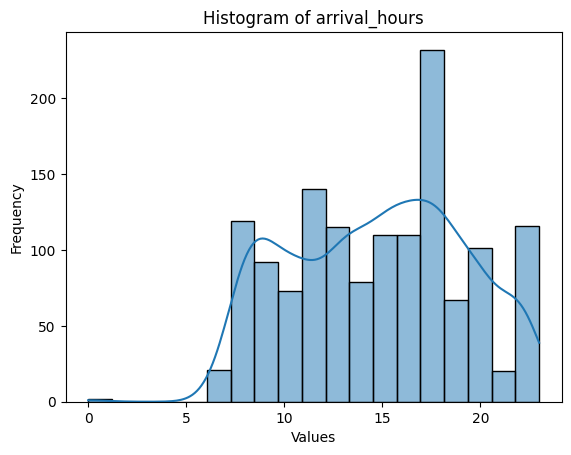

In [65]:
sns.histplot(data=arrival_hours, kde=True)
plt.title(f'Histogram of arrival_hours')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

### Crosstab
We have used crosstab function of pandas to understand the freduency among two attributes. The `departure_airport` and `arrival_airports` are compared with number of stops.

In [66]:
departure_airport_stop = pd.crosstab(df_flight['departure_airport'],df_flight['stops'])
departure_airport_stop

stops,0.0,1.0,2.0
departure_airport,,,
Kitchener-Waterloo,0,4,1
Pearson Intl,376,105,0
Toronto Island,775,134,2


Pearson Intl and Toronto Island are the primary departure points with a majority of direct flights (0 stops), while Kitchener-Waterloo have minimal flight operations.

In [67]:
arrival_airport_stop = pd.crosstab(df_flight['arrival_airport'],df_flight['stops'])
arrival_airport_stop

stops,0.0,1.0,2.0
arrival_airport,,,
John F Kennedy Intl,74,4,0
LaGuardia,216,37,0
Newark,861,202,3


 Newark is the most common destination airport for flights with a variety of stop counts, especially for direct flights (0 stops), while John F Kennedy Intl has the least flight activity, indicating a clear preference for Newark as a destination.


## Step 4 Pandas Profiling

In [28]:
profile = ProfileReport(df_flight, title='Pandas Profiling Report', explorative=True)

#save to html file
profile.to_file(r".\flight_data_profile.html")


NameError: name 'ProfileReport' is not defined

In [68]:
df_flight

,date,departure_city,departure_airport,arrival_city,stops,prices,flight_duration,arrival_airport,departure_time,arrival_time
0,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,12:00:00,13:30:00
1,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,15:00:00,16:30:00
2,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,14:00:00,15:30:00
3,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,17:10:00,18:40:00
4,12/19/2024,YTZ,Toronto Island,EWR,0.0,227,90,Newark,19:25:00,20:55:00
...,...,...,...,...,...,...,...,...,...,...
1478,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,90,Newark,20:40:00,22:10:00
1479,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,90,Newark,15:00:00,16:30:00
1480,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,90,Newark,19:25:00,20:55:00
1481,6/12/2024,YTZ,Toronto Island,EWR,0.0,177,240,Newark,07:55:00,09:25:00


## Step 5 Encoding

In [69]:
categorical_columns = ['departure_city', 'departure_airport', 'arrival_city', 'arrival_airport']

We have 4 categorical columns in our dataset, all four of which are nominal categorical variables. As discussed in the class, the proper way to encode categorical nominal value is either by label encoding or one hot encoding. We have applied one hot encoding to those columns, which generates new numerical columns in place of the categorical columns.

In [70]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

def cat_column_encode(df, categorical_columns):
    encoder = OneHotEncoder(sparse_output=False)
    df_reset = df.reset_index(drop=True)
    features = encoder.fit_transform(df_reset[categorical_columns])
    onehotencoder = pd.DataFrame(features, columns=encoder.get_feature_names_out(categorical_columns))
    encoded_df = pd.concat([df_reset.drop(categorical_columns, axis=1), onehotencoder], axis=1)
    return encoded_df

encoded_df = cat_column_encode(df_flight, categorical_columns)
print(f"Original column count: {df_flight.shape[1]}, Encoded column count: {encoded_df.shape[1]}")


Original column count: 10, Encoded column count: 18


In [71]:
encoded_df

,date,stops,prices,flight_duration,departure_time,arrival_time,departure_city_YKF,departure_city_YTZ,departure_city_YYZ,departure_airport_Kitchener-Waterloo,departure_airport_Pearson Intl,departure_airport_Toronto Island,arrival_city_EWR,arrival_city_JFK,arrival_city_LGA,arrival_airport_John F Kennedy Intl,arrival_airport_LaGuardia,arrival_airport_Newark
0,12/19/2024,0.0,227,90,12:00:00,13:30:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1,12/19/2024,0.0,227,90,15:00:00,16:30:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
2,12/19/2024,0.0,227,90,14:00:00,15:30:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,12/19/2024,0.0,227,90,17:10:00,18:40:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,12/19/2024,0.0,227,90,19:25:00,20:55:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1392,6/12/2024,0.0,177,90,20:40:00,22:10:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1393,6/12/2024,0.0,177,90,15:00:00,16:30:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1394,6/12/2024,0.0,177,90,19:25:00,20:55:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
1395,6/12/2024,0.0,177,240,07:55:00,09:25:00,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


New Columns in the encoded_df are:


In [72]:
encoded_df.columns

Index(['date ', 'stops', 'prices', 'flight_duration', 'departure_time',
       'arrival_time', 'departure_city_YKF', 'departure_city_YTZ',
       'departure_city_YYZ', 'departure_airport_Kitchener-Waterloo',
       'departure_airport_Pearson Intl', 'departure_airport_Toronto Island',
       'arrival_city_EWR', 'arrival_city_JFK', 'arrival_city_LGA',
       'arrival_airport_John F Kennedy Intl', 'arrival_airport_LaGuardia',
       'arrival_airport_Newark'],
      dtype='object')

In [73]:
encoded_df.to_csv('encoded_df.csv', index=False)

## Step 6 Outlier Detection

We have three numerical attributes in the dataset we need to determine the outlier for. 

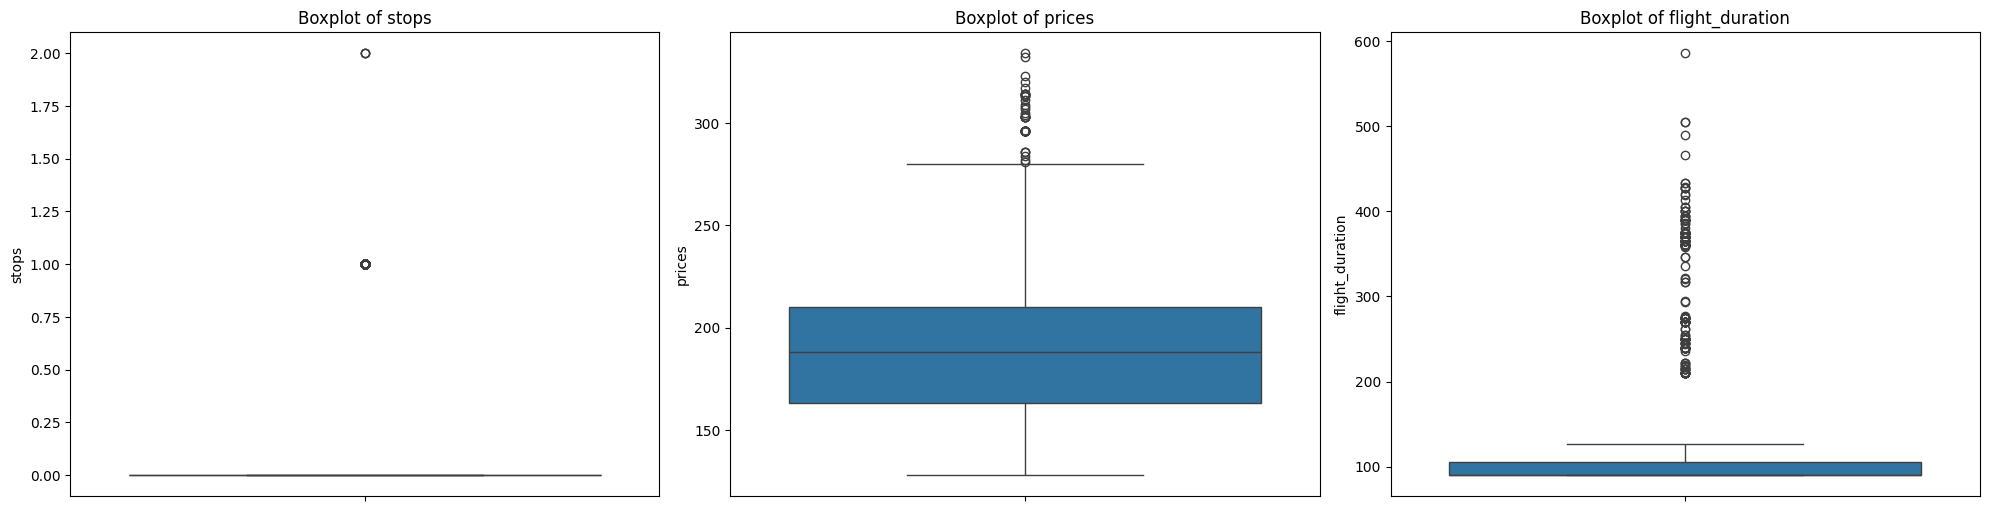

In [74]:
# numerical columns for visualization
numerical_columns = ['stops', 'prices', 'flight_duration']
plt.figure(figsize=(20, 10))

# create a boxplot for each numerical columns
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)  # Create subplot for each column
    sns.boxplot(y=encoded_df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

In [75]:
# numerical columns for outlier analysis
numericalcolumns = ['stops', 'prices', 'flight_duration']

# create a dictionary to store the information
outliers = {}

# calculate IQR and identify outliers by iterating thriugh each of those columns
for col in numericalcolumns:
    Q1 = encoded_df[col].quantile(0.25)
    Q3 = encoded_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR

    # Identify outliers and store their counts
    outlier = encoded_df[(encoded_df[col] < lower_whisker) | (encoded_df[col] > upper_whisker)][col]
    outliers[col] = len(outlier)

outliers


{'stops': 246, 'prices': 63, 'flight_duration': 247}

There were a considerable amount of outliers in the flight_duration and stops. Since this is a data that we extracted from the internet, this are most likely to be an actual value and not outliers or noisy data in the dataset.

# Step 7 Addressing outliers


## Initial Histogram and Boxplot

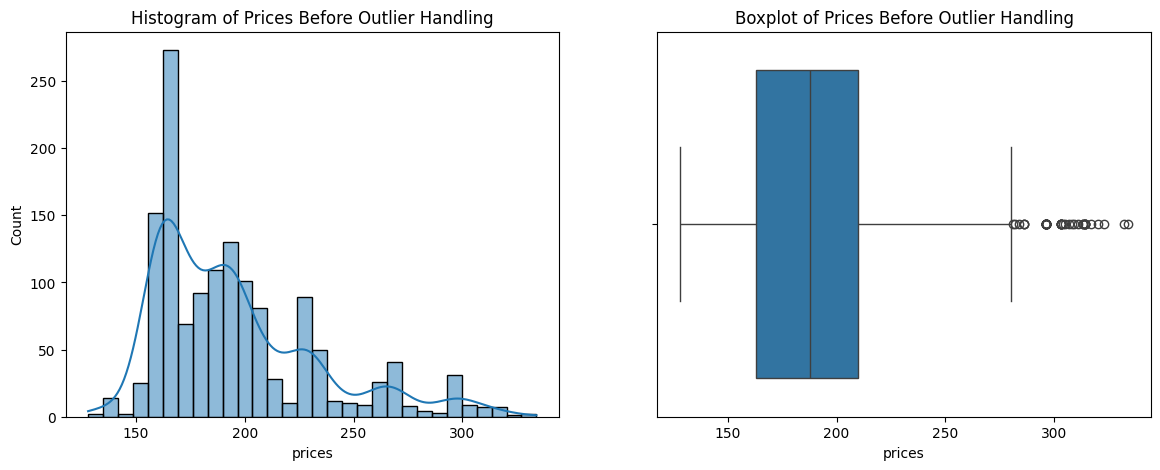

In [76]:
# Histogram and Boxplot before applying outlier handling
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_flight['prices'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Prices Before Outlier Handling')
sns.boxplot(x=df_flight['prices'], ax=ax[1])
ax[1].set_title('Boxplot of Prices Before Outlier Handling')
plt.show()


## 1. Quantile-based Flooring and Capping

In [77]:
# Quantile-based Flooring and Capping for 'prices'
q_low = df_flight['prices'].quantile(0.01)
q_high = df_flight['prices'].quantile(0.99)

df_flight['prices_capped'] = df_flight['prices'].clip(lower=q_low, upper=q_high)


## 2. Trimming

In [97]:
# Trimming outliers based on 'prices'
print(lower_whisker)
print(upper_whisker)

df_flight_trimmed = df_flight[(df_flight['prices'] > lower_whisker) & (df_flight['prices'] < upper_whisker)]
df_flight_trimmed


67.5
127.5


,date,departure_city,departure_airport,arrival_city,stops,prices,flight_duration,arrival_airport,departure_time,arrival_time,prices_capped,log_prices,cluster


## 3. Log Transformation

In [86]:
# Log Transformation for 'prices'
df_flight['log_prices'] = np.log1p(df_flight['prices'])

## Histograms and Boxplots After Applying Techniques

## 1. Quantile-based Flooring and Capping

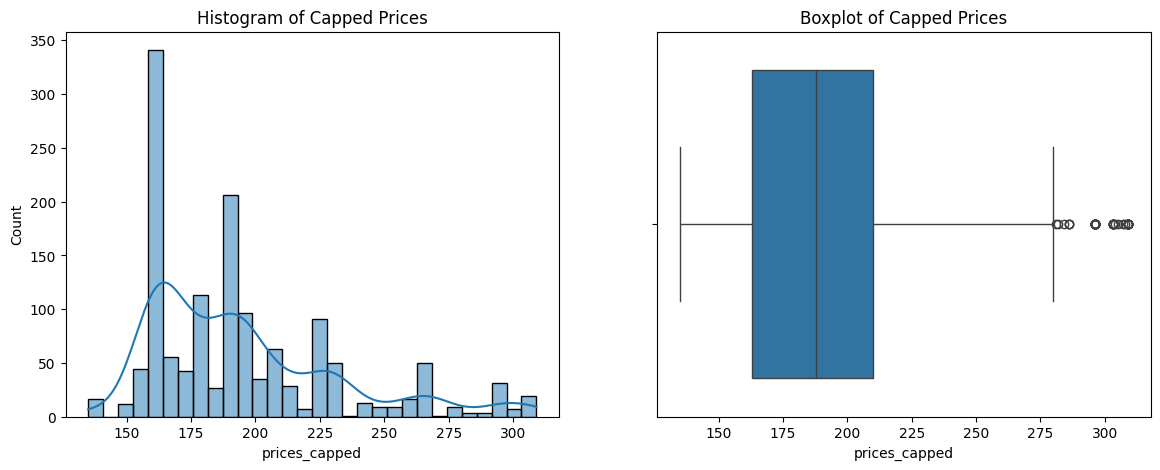

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_flight['prices_capped'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Capped Prices')
sns.boxplot(x=df_flight['prices_capped'], ax=ax[1])
ax[1].set_title('Boxplot of Capped Prices')
plt.show()

## 2. Trimming

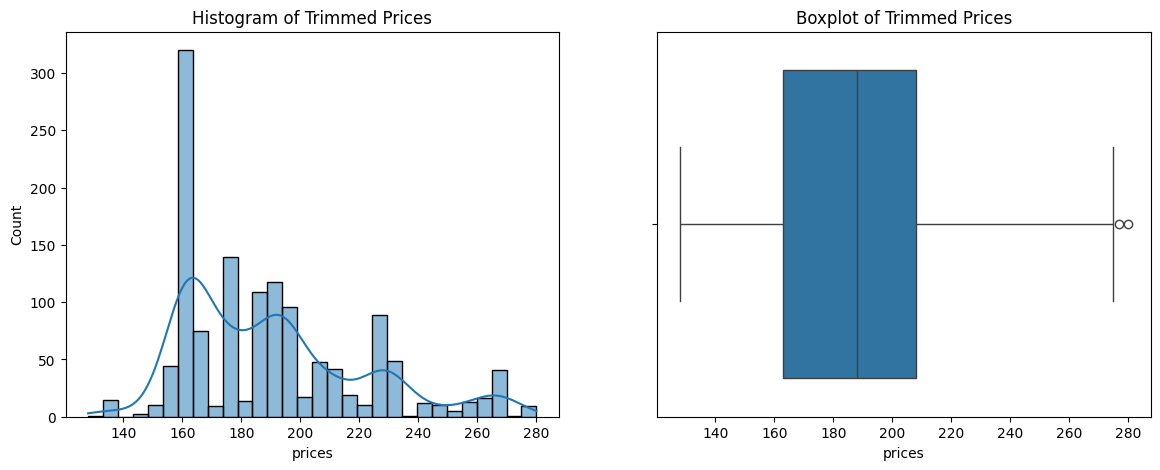

In [98]:
Q1 = df_flight["prices"].quantile(0.25)
Q3 = df_flight["prices"].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
df_flight_trimmed = df_flight[(df_flight['prices'] > lower_whisker) & (df_flight['prices'] < upper_whisker)]
sns.histplot(df_flight_trimmed['prices'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Trimmed Prices')
sns.boxplot(x=df_flight_trimmed['prices'], ax=ax[1])
ax[1].set_title('Boxplot of Trimmed Prices')
plt.show()

## 3. Log Transformation

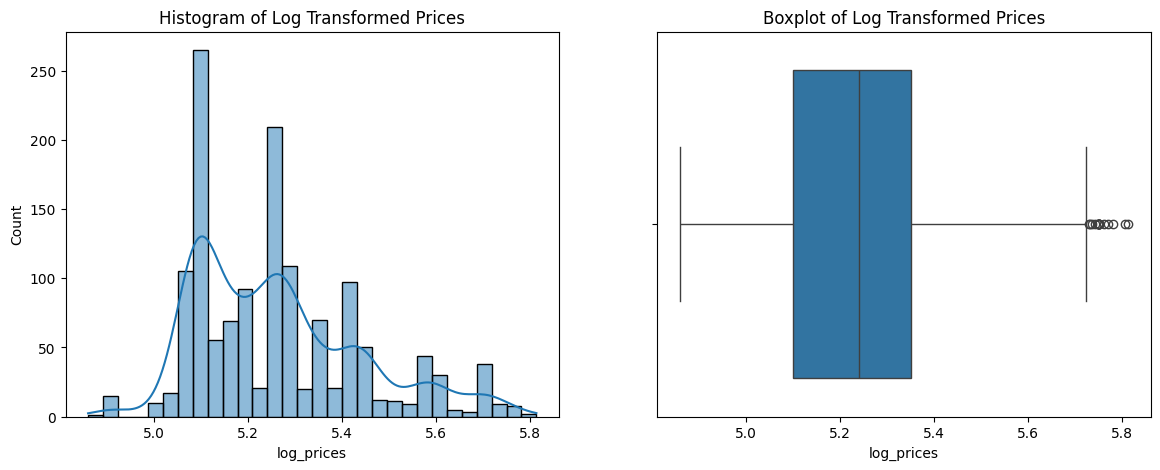

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(df_flight['log_prices'], bins=30, kde=True, ax=ax[0])
ax[0].set_title('Histogram of Log Transformed Prices')
sns.boxplot(x=df_flight['log_prices'], ax=ax[1])
ax[1].set_title('Boxplot of Log Transformed Prices')
plt.show()

In [101]:
print(df_flight['prices'].skew().round(2))
print(df_flight['log_prices'].skew().round(2))

1.22
0.82


# Step 8 Unsupervised Learning Methods

In order to determine what features we want to perform Unsupervised learning methods, we first make scatterplots between the numerical attributes to see if we can determine some relation between them.

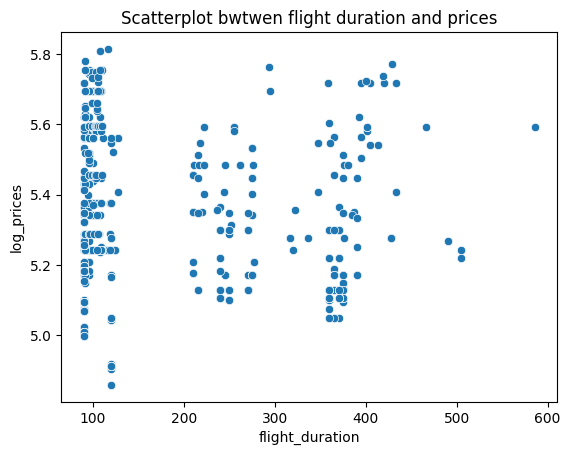

In [90]:
sns.scatterplot(data=df_flight, x='flight_duration', y='log_prices')
plt.title('Scatterplot bwtwen flight duration and prices')
plt.show()


Comparing the flight duration and prices, we see a relation bwtween the data where we will be able to form cluters. Therefore, we select these attributes.

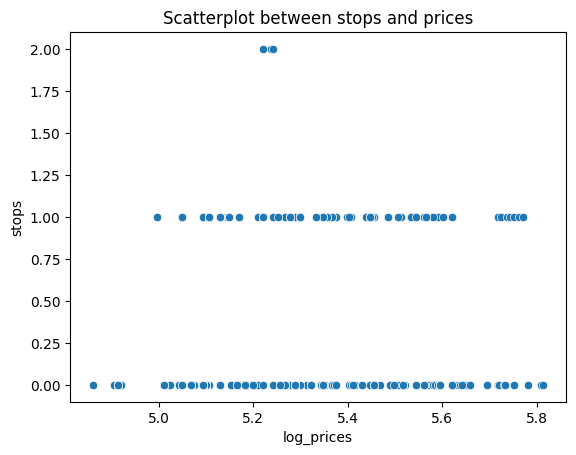

In [91]:
sns.scatterplot(data=df_flight, x='log_prices', y='stops')
plt.title('Scatterplot between stops and prices')
plt.show()


Text(0.5, 1.0, 'Scatterplot between flight duration and stops')

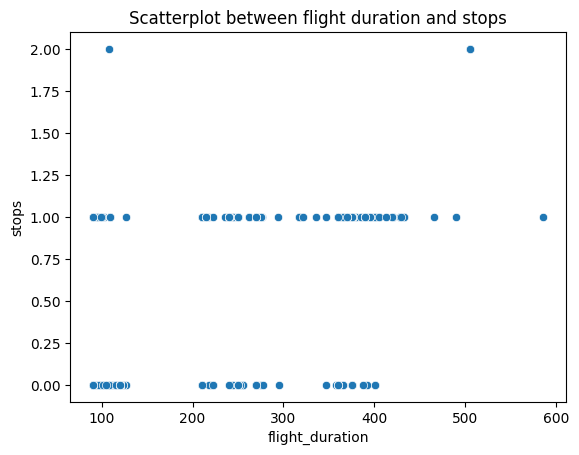

In [92]:
sns.scatterplot(data=df_flight, x='flight_duration', y='stops')
plt.title('Scatterplot between flight duration and stops')


## K-Means Clustering

In [93]:
X = df_flight[['flight_duration', 'log_prices']]

### Determination of Number of Clusters using Elbow method

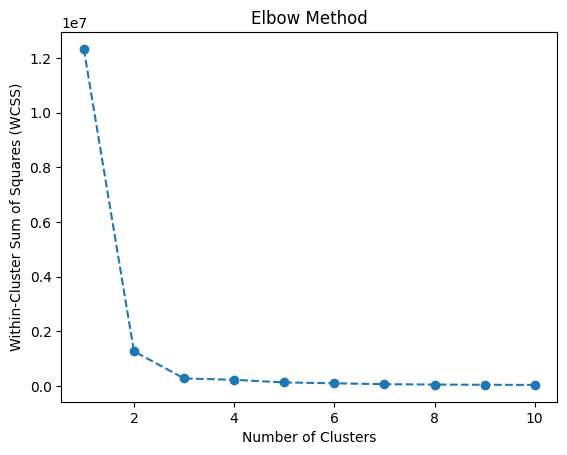

In [99]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

### No. of Clusters = 3

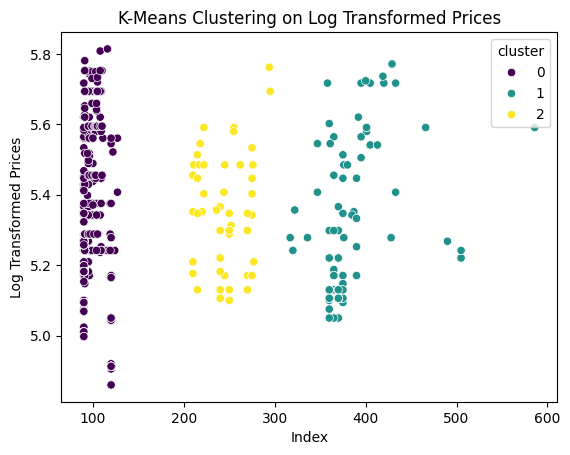

In [95]:
from sklearn.cluster import KMeans

# Using log_prices for a more normalized distribution

kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
df_flight['cluster'] = kmeans.labels_

sns.scatterplot(data=df_flight, x='flight_duration', y='log_prices', hue='cluster', palette='viridis')
plt.title('K-Means Clustering on Log Transformed Prices')
plt.xlabel('Index')
plt.ylabel('Log Transformed Prices')
plt.show()


We can see that even visually, K-Means clustering shows good output, which means that the model is accurate at detecting clusters

# DBSCAN

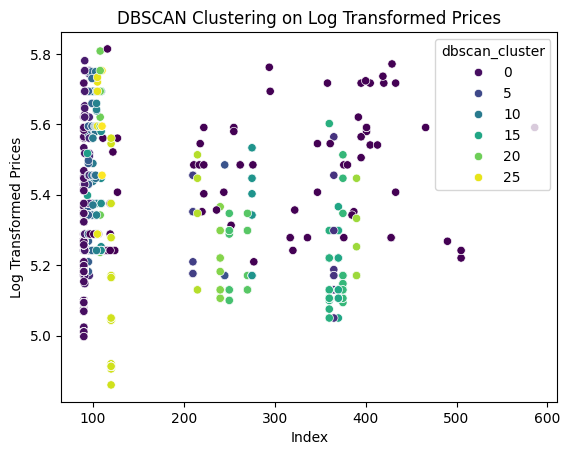

In [206]:
from sklearn.cluster import DBSCAN

# Adjust eps and min_samples based on the dataset
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(X)
df_flight['dbscan_cluster'] = dbscan.labels_

sns.scatterplot(data=df_flight, x='flight_duration', y='log_prices', hue='dbscan_cluster', palette='viridis')
plt.title('DBSCAN Clustering on Log Transformed Prices')
plt.xlabel('Index')
plt.ylabel('Log Transformed Prices')
plt.show()


DBSCAN is not able to detect the clusters well, as we know that if the density of data points varies significantly across the dataset, DBSCAN may have difficulty defining clusters accurately. This is the case here.

# Aglomerative clustering

In [211]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

agg_clustering = AgglomerativeClustering(n_clusters=4, linkage='ward')
df_flight['agg_cluster'] = agg_clustering.fit_predict(X)


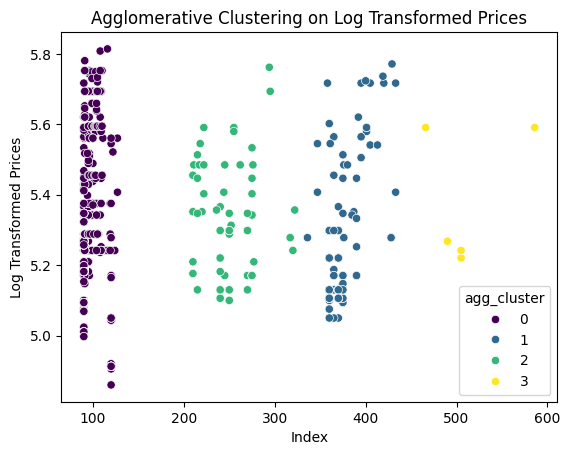

In [212]:
# Plotting the clusters
sns.scatterplot(data=df_flight, x="flight_duration", y='log_prices', hue='agg_cluster', palette='viridis')
plt.title('Agglomerative Clustering on Log Transformed Prices')
plt.xlabel('Index')
plt.ylabel('Log Transformed Prices')
plt.show()

Visually, Agglomerative Clustering works better than DBSCAN clustering.

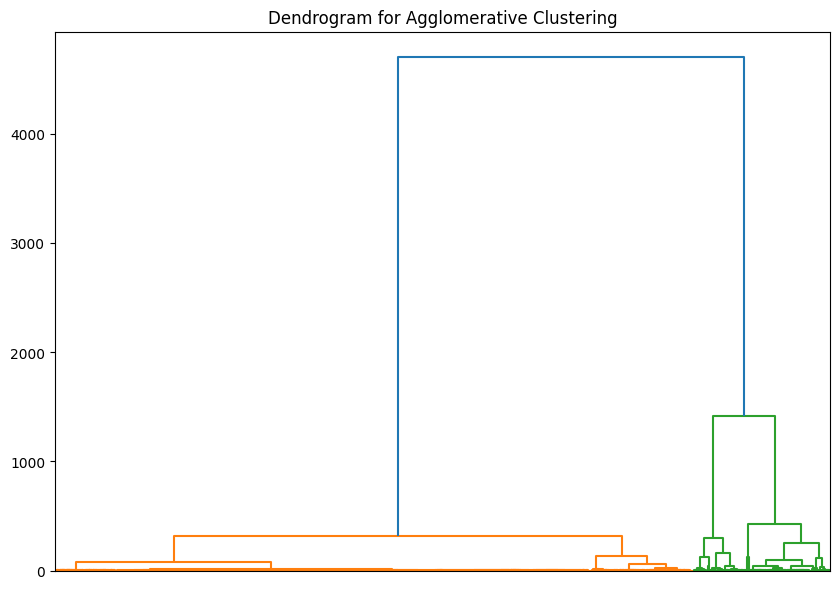

In [191]:
from scipy.cluster.hierarchy import ward, dendrogram

# Compute the linkage matrix using the ward method for the same feature set
linkage_matrix = ward(X)

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, no_labels=True)
plt.title('Dendrogram for Agglomerative Clustering')
plt.show()

# Comparison

Silhouette Score for K-Means: 0.929
Silhouette Score for Agglomerative Clustering: 0.929
Silhouette Score for DBSCAN Clustering: 0.777


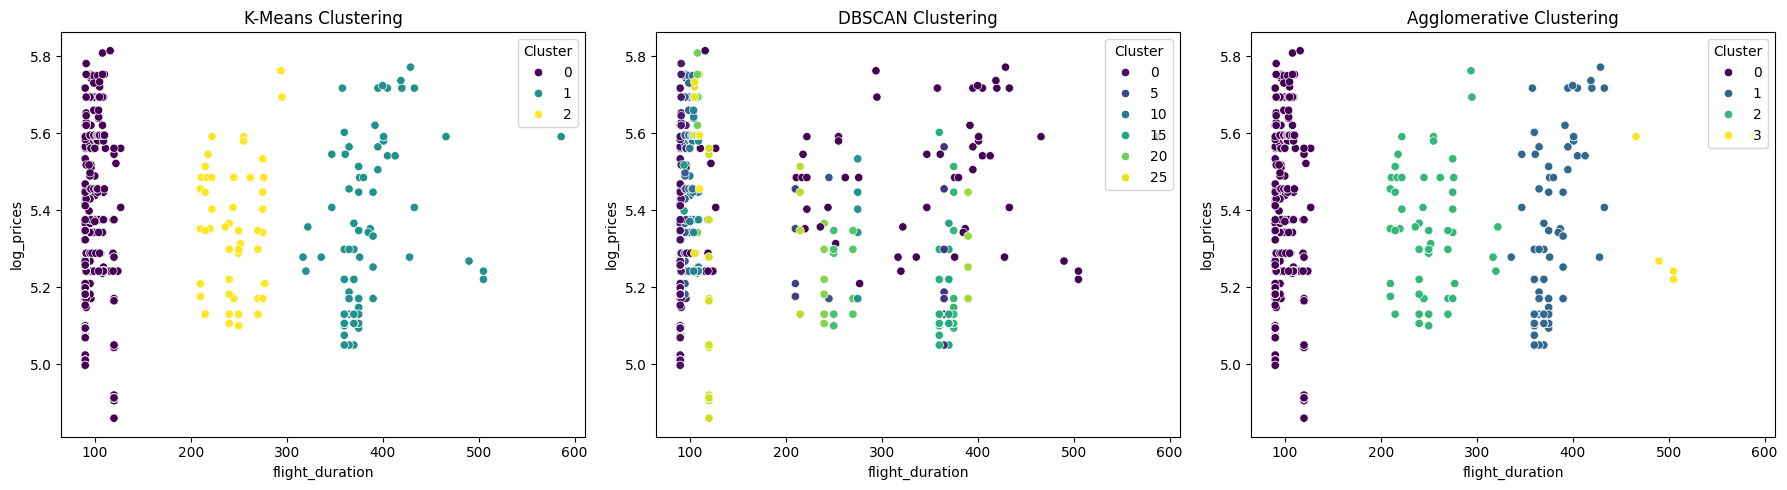

In [215]:
from sklearn.metrics import silhouette_score

# Calculate silhouette scores for K-Means and Agglomerative Clustering
silhouette_kmeans = silhouette_score(X, df_flight['cluster'])
silhouette_agg = silhouette_score(X, df_flight['agg_cluster'])
silhouette_dbscan = silhouette_score(X, df_flight['dbscan_cluster'])


print(f"Silhouette Score for K-Means: {silhouette_kmeans:.3f}")
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agg:.3f}")
print(f"Silhouette Score for DBSCAN Clustering: {silhouette_dbscan:.3f}")


# Visualizing the clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means Clusters
sns.scatterplot(ax=axes[0], x='flight_duration', y='log_prices', hue='cluster', palette='viridis', data=df_flight)
axes[0].set_title('K-Means Clustering')
axes[0].legend(title='Cluster', loc='upper right')

# DBSCAN Clusters
sns.scatterplot(ax=axes[1], x='flight_duration', y='log_prices', hue='dbscan_cluster', palette='viridis', data=df_flight)
axes[1].set_title('DBSCAN Clustering')
axes[1].legend(title='Cluster', loc='upper right')

# Agglomerative Clusters
sns.scatterplot(ax=axes[2], x='flight_duration', y='log_prices', hue='agg_cluster', palette='viridis', data=df_flight)
axes[2].set_title('Agglomerative Clustering')
axes[2].legend(title='Cluster', loc='upper right')

plt.tight_layout()
plt.show()


**K-Means:**
Silhouette Score: 0.929
Interpretation:
- Data points are very well matched to their own clusters.
- Data points are poorly matched to neighboring clusters.
- Indicates dense, well-separated clusters.


**Agglomerative Clustering:**
Silhouette Score: 0.929
Interpretation:
- Similar performance to K-Means.
- Data points are very well matched to their own clusters.
- Data points are poorly matched to neighboring clusters.
- Indicates dense, well-separated clusters.


**DBSCAN:**
Silhouette Score: 0.777
Interpretation:
- Slightly lower score compared to K-Means and Agglomerative Clustering.
- Data points are reasonably well matched to their own clusters.
- Data points are less well matched to neighboring clusters compared to K-Means and Agglomerative Clustering.
